# Chapter 2

Concepts and data from "An Introduction to Statistical Learning, with applications in R"  (Springer, 2013) with permission from the authors: G. James, D. Witten,  T. Hastie and R. Tibshirani " available at [www.StatLearning.com](http://www.StatLearning.com).

For Tables reference see [http://data8.org/datascience/tables.html](http://data8.org/datascience/tables.html)

http://jeffskinnerbox.me/notebooks/matplotlib-2d-and-3d-plotting-in-ipython.html


In [1]:
# HIDDEN
# For Tables reference see http://data8.org/datascience/tables.html
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
import numpy as np
from sklearn import linear_model
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__


import sys
sys.path.append("..")
from ml_table import ML_Table

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

'en_US.UTF-8'

# Acquiring and seeing trends in multidimensional data

In [2]:
advertising = ML_Table.read_table("./data/Advertising.csv")
advertising.relabel(0, "id")

id,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
6,8.7,48.9,75,7.2
7,57.5,32.8,23.5,11.8
8,120.2,19.6,11.6,13.2
9,8.6,2.1,1,4.8
10,199.8,2.6,21.2,10.6


## Figure 2.1

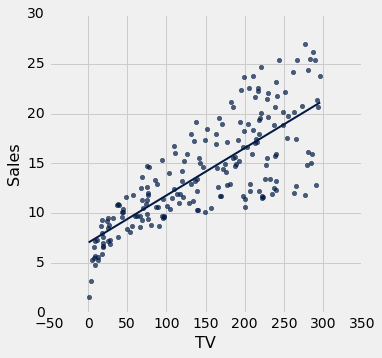

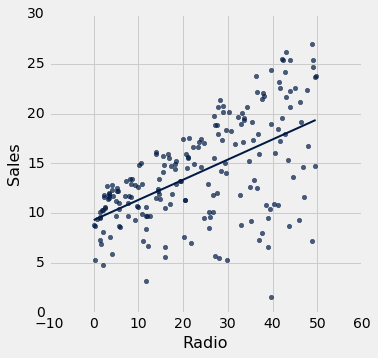

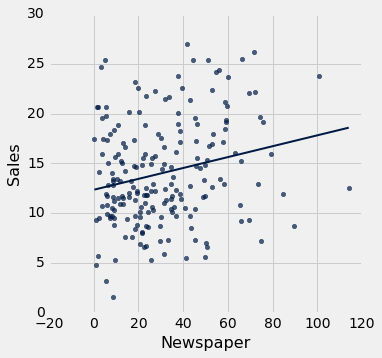

In [3]:
for col in ['TV', 'Radio', 'Newspaper']:
    advertising.select([col, 'Sales']).scatter(col, fit_line=True)

# Model and irreducible error

In [4]:
# Create synthetic data with output value variying around a
# model given by a function by a noise term
def simdata(n, f, eps, low, high):
    x_tbl = ML_Table().sequence('x', n, low, high)
    s_tbl = ML_Table().with_column('i', range(n))
    s_tbl['x'] = x_tbl.sample()['x']+ (np.random.rand(n)-0.5)/(2*n)                
    s_tbl['f'] = s_tbl.apply(f, 'x')
    s_tbl['Y'] = s_tbl['f'] + eps*(np.random.rand(n)-0.5)
    return s_tbl   

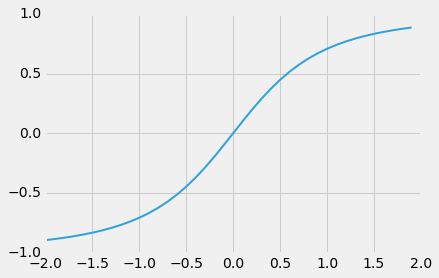

In [5]:
def sigmoid(x):
    return x/((1+x**2)**0.5)
plots.plot(np.arange(-2,2, .1), list(map(sigmoid, np.arange(-2,2, .1))))

# Figure 2.2

In [6]:
# Complication function modeling how income varies with years of education
def edfun(year):
    x = (year-15)/3
    return (sigmoid(x)+1)*35+20

In [7]:
ed_data = simdata(40, edfun, 10, 10, 22).select(['x', 'Y'])
ed_data.relabel('x', 'Years of Education')
ed_data.relabel('Y', 'Income')
ed_data

Years of Education,Income
10.9044,28.5287
12.1058,31.8753
9.99706,21.1371
21.7008,88.9909
10.3043,29.0666
21.099,89.2223
15.7046,63.645
21.3946,83.2659
18.4054,81.3382
12.6947,37.9486


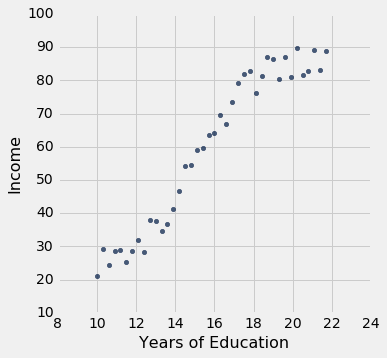

In [8]:
# What wold this data look like?
ed_data.scatter('Years of Education')

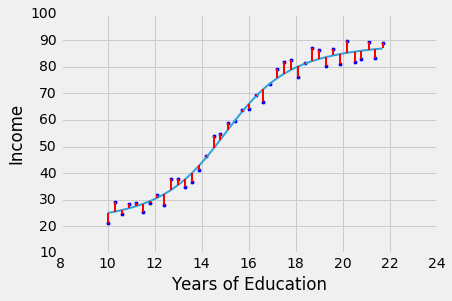

In [9]:
# Visualize the noise relative to the underlying model
ed_data.plot_fit('Income', edfun)

## Bias - Variance Tradeoff

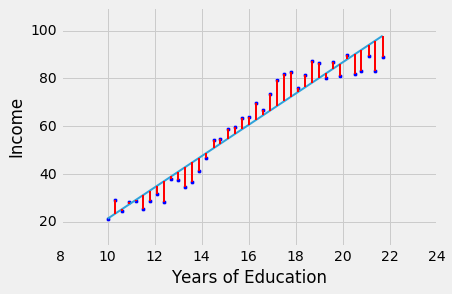

In [10]:
# Fit a linear model and plot the goodness of fit
ed_data.plot_fit('Income', ed_data.regression('Income'))

In [11]:
def show_mse_fit(deg):
    model = ed_data.poly('Income', 'Years of Education', deg)
    ed_data.plot_fit('Income', model)
    data_mse = ed_data.MSE('Income', ed_data.apply(model, 'Years of Education'))
    true_mse = ed_data.MSE(ed_data.apply(edfun, 'Years of Education'), ed_data.apply(model, 'Years of Education'))
    return data_mse, true_mse

(28.184909128805771, 17.635155846741121)

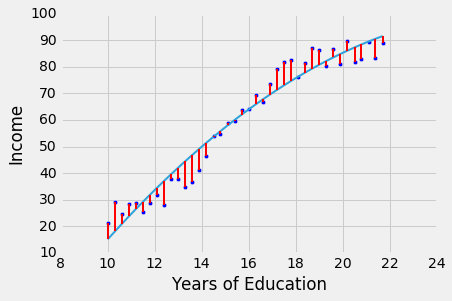

In [12]:
show_mse_fit(2)

/Users/culler/anaconda/envs/cs88/lib/python3.5/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


(7.6237002492061849, 1.6471126600783077)

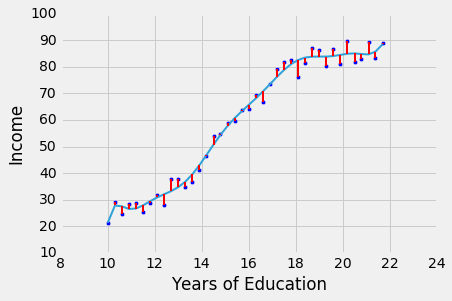

In [13]:
interact(show_mse_fit, deg=widgets.IntSlider(min=1,max=20,step=1,value=1))

## Multidimensional model and data

In [14]:
def simdata2D(n, f, eps, low, high):
    x_tbl = ML_Table().sequence('x', n, low, high)
    s_tbl = ML_Table().with_column('i', range(n))
    s_tbl['x'] = x_tbl.sample()['x']+ (np.random.rand(n)-0.5)/(2*n) 
    s_tbl['y'] = x_tbl.sample()['x']+ (np.random.rand(n)-0.5)/(2*n)    
    s_tbl['f'] = s_tbl.apply(f, ['x', 'y'])
    s_tbl['Z'] = s_tbl['f'] + eps*(np.random.rand(n)-0.5)
    return s_tbl   

In [15]:
# Complication function modeling how income varies with years of education
def edfun2(year, seniority):
    # year in [10, 22], seniority in [0-30]
    x = (year-16)/3
    y = (seniority-15)/7.5
    return (sigmoid(x)+1)*35+20 + (sigmoid(y)+1)*25+20

<function __main__.show_income_per_ed>

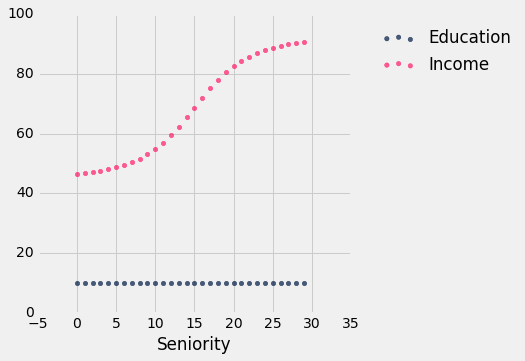

In [16]:
def show_income_per_ed(ed_years):
    ts = ML_Table().with_column('Seniority', np.arange(0,30))
    ts['Education'] = ed_years
    ts['Income'] = ts.apply(edfun2, ['Education', 'Seniority'])
    ts.scatter('Seniority')
    
interact(show_income_per_ed, ed_years=widgets.IntSlider(min=10,max=22,step=1,value=10))

In [17]:
# Create some two variable data using this model
n = 50
eps = .2
year_tbl = ML_Table().sequence('x', n, 10, 22)
seniority_tbl = ML_Table().sequence('x', n, 1, 20)
sy_table = ML_Table().with_columns(['Years of Education',
                                year_tbl.sample()['x'],
                                'Seniority',
                                seniority_tbl.sample()['x']])
sy_table['Ideal Income'] = sy_table.apply(edfun2, ['Years of Education', 'Seniority'])
sy_table['Income'] = sy_table['Ideal Income']*(1 + 2*eps*(np.random.rand(n)-0.5))
sy_table

Years of Education,Seniority,Ideal Income,Income
14.8,2.9,65.7522,65.3198
21.76,12.4,122.853,119.731
15.52,7.46,76.7457,64.8414
19.12,11.26,114.073,114.603
11.68,16.96,77.5731,67.1862
16.24,7.84,85.528,100.353
18.4,15.82,124.581,104.784
20.32,12.78,121.652,98.076
13.84,3.28,58.4919,61.6457
18.16,5.94,101.193,119.737


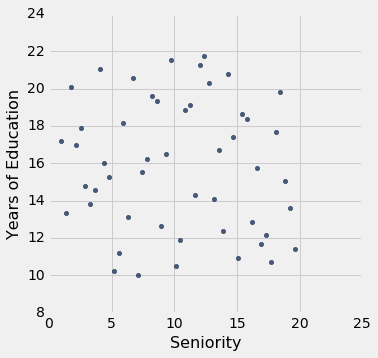

In [18]:
# Where are the sample points in the input space?
sy_table.select(['Years of Education', 'Seniority']).scatter('Seniority')

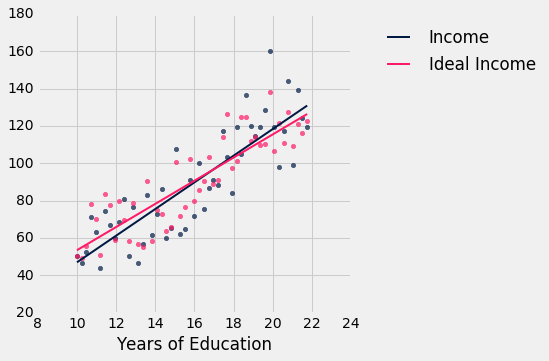

In [19]:
# Looking at only one input, either just the model (ideal) or what a sample miight produce
sy_table.select(['Income', 'Ideal Income', 'Years of Education']).scatter('Years of Education', fit_line=True)

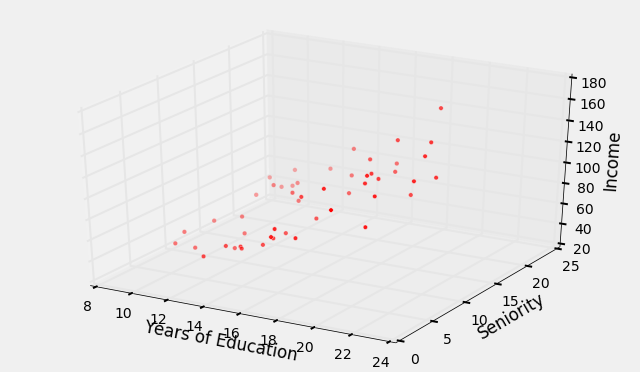

In [20]:
# The data in 3D
sy_table.plot_fit_2d("Income", "Years of Education", "Seniority", width=10, height=6)

## Figure 2.3

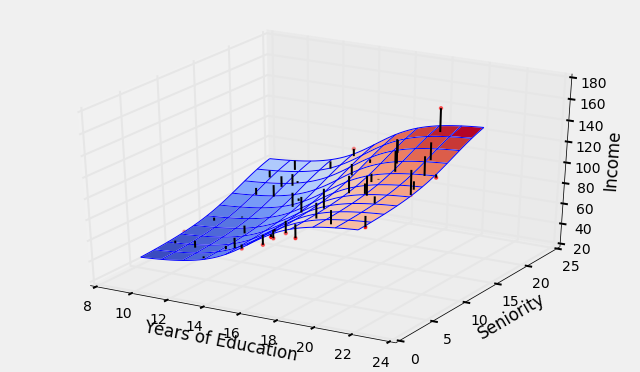

In [21]:
# The data and its relation to the model
sy_table.plot_fit_2d("Income", "Years of Education", "Seniority", edfun2, width=10,height=6)

Expected value of squared difference of actual and expected value: 
$$E(Y - \hat{Y})^2 = E[ f(X) + \epsilon - \hat{f}(X) ]^2$$
$$ = [f(X) - \hat{f}(X)]^2 + Var(\epsilon)$$

## Figure 2.4

Linear model fit to the (simulated) education data in `sy_table`.

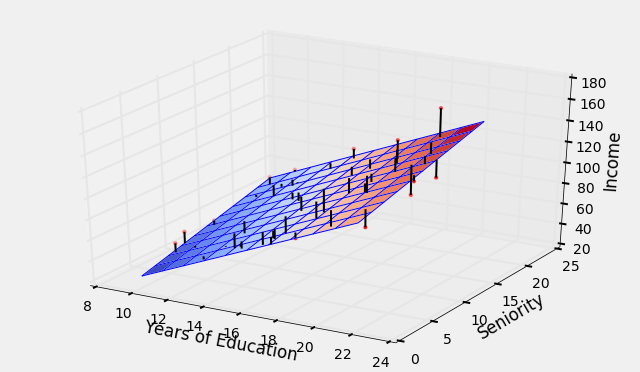

In [22]:
sim_ed = sy_table.drop('Ideal Income')
sim_lin_model = sim_ed.regression('Income')
sim_ed.plot_fit_2d('Income', 'Years of Education', 'Seniority', sim_lin_model, width=10, height=6)

In [23]:
sim_ed["F^"] = sim_ed.apply(sim_lin_model, ['Years of Education', 'Seniority'])
sim_ed.MSE('Income', 'F^')

130.26389610525683

In [24]:
sim_ed["Model"] = sim_ed.apply(edfun2, ['Years of Education', 'Seniority'])
sim_ed.MSE('Income', 'Model')

127.53388710884467

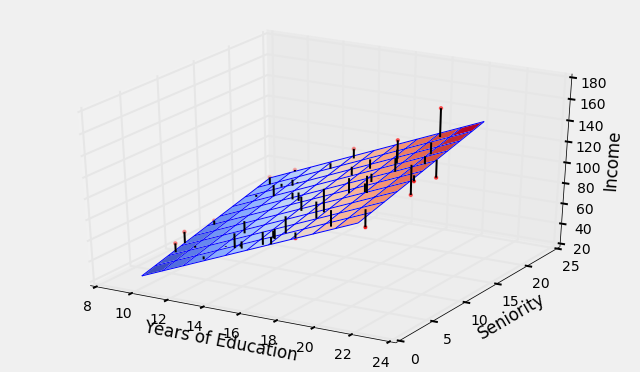

In [25]:
sim_ridge_model = sim_ed.select(['Years of Education', 'Seniority', 'Income']).ridge('Income')
sim_ed.plot_fit_2d('Income', 'Years of Education', 'Seniority', sim_ridge_model , width=10, height=6)